In [1]:
!pip install -U spacy
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 10.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import string
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import spacy
import torch
from transformers import BertTokenizer, BertModel , BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

In [3]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
# Load the dataset
xls = pd.ExcelFile('Restaurant_Reviews.xlsx', engine='openpyxl')
data = xls.parse(0, engine='openpyxl')
data

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


Data Preprocessing:
1. Remove any duplicates or irrelevant columns.
2. Tokenize the text data.
3. Handle missing values if any.

In [5]:
# Remove duplicates
data = data.drop_duplicates()
# Remove irrelevant columns if any
data = data[['Review', 'Liked']]
# Tokenization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_text(text):
    if pd.isnull(text):
        return []
    tokens = word_tokenize(str(text).lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum()]
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

data['Tokenized_Review'] = data['Review'].apply(tokenize_text)
# Handle missing values if any
data.dropna(inplace=True)
print(data)

                                                Review  Liked  \
0                             Wow... Loved this place.      1   
1                                   Crust is not good.      0   
2            Not tasty and the texture was just nasty.      0   
3    Stopped by during the late May bank holiday of...      1   
4    The selection on the menu was great and so wer...      1   
..                                                 ...    ...   
995  I think food should have flavor and texture an...      0   
996                           Appetite instantly gone.      0   
997  Overall I was not impressed and would not go b...      0   
998  The whole experience was underwhelming, and I ...      0   
999  Then, as if I hadn't wasted enough of my life ...      0   

                                      Tokenized_Review  
0                                  [wow, loved, place]  
1                                        [crust, good]  
2                          [tasty, texture, wa, 

Exploratory Data Analysis (EDA):

1. Understand the distribution of the 'Liked' column (positive, negative, neutral).
2. Visualize the data distribution.
3. Check for any class imbalances.

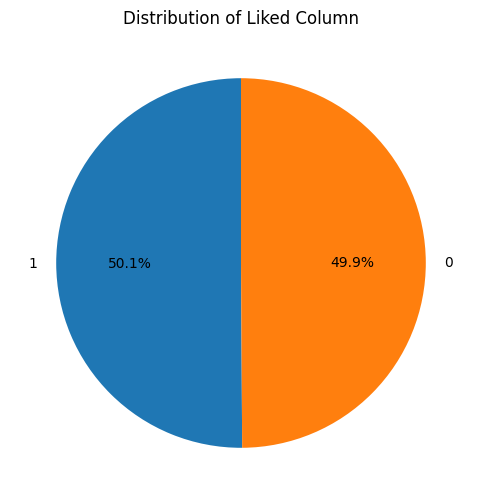

Class Counts:
Liked
1    497
0    495
Name: count, dtype: int64
Class Imbalance Ratio (0:Negative to 1:Positive): 0.9959758551307847


In [6]:
# Understanding the distribution of the 'Liked' column
liked_distribution = data['Liked'].value_counts(normalize=True)
# Visualizing the data distribution
plt.figure(figsize=(6, 6))
plt.pie(liked_distribution, labels=liked_distribution.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Liked Column')
plt.show()
# Checking for class imbalances
class_counts = data['Liked'].value_counts()
print("Class Counts:")
print(class_counts)
# Calculate class imbalance ratio
imbalance_ratio = class_counts[0] / class_counts[1]
print("Class Imbalance Ratio (0:Negative to 1:Positive):", imbalance_ratio)

Feature Engineering:

1. Convert the text data into numerical format using techniques like TF-IDF and Word Embeddings (Word2Vec, GloVe).
2. using transformers like BERT.

In [7]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust the max_features parameter as needed
# Fit-transform the text data
tfidf_features = tfidf_vectorizer.fit_transform(data['Review'])
# Convert sparse matrix to DataFrame for visualization
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
# Display the TF-IDF DataFrame
print(tfidf_df.head())

    10  100   12   20   30   35   40   90   99  about  ...  years  yellowtail  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  ...    0.0         0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  ...    0.0         0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  ...    0.0         0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  ...    0.0         0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  ...    0.0         0.0   

   yelpers  yet  you  your  yourself  yum  yummy  zero  
0      0.0  0.0  0.0   0.0       0.0  0.0    0.0   0.0  
1      0.0  0.0  0.0   0.0       0.0  0.0    0.0   0.0  
2      0.0  0.0  0.0   0.0       0.0  0.0    0.0   0.0  
3      0.0  0.0  0.0   0.0       0.0  0.0    0.0   0.0  
4      0.0  0.0  0.0   0.0       0.0  0.0    0.0   0.0  

[5 rows x 1000 columns]


In [8]:
# For Word2Vec
# Tokenize the text data (assuming data['Review'] is a list of strings)
tokenized_reviews = [review.split() for review in data['Review']]
word2vec_model = Word2Vec(tokenized_reviews, vector_size=100, window=5, min_count=1, sg=0)
# Example of getting Word2Vec embedding for a word
print(word2vec_model.wv['good'])
# For GloVe, you can download pre-trained embeddings and load them
# For example, using spaCy
nlp = spacy.load('en_core_web_md')
# Example of getting GloVe embedding for a word
print(nlp.vocab['good'].vector)

[-0.03038137  0.01600241 -0.00650682  0.02208941  0.0080939  -0.05147452
  0.04726608  0.07379987 -0.04742503 -0.02291884 -0.02201561 -0.04513041
 -0.0067014   0.01854253  0.00108913 -0.02949841  0.01827809 -0.05078991
  0.00154668 -0.07327827  0.03353114  0.00942359  0.04581327 -0.02798068
 -0.01284497 -0.00946291 -0.03092986 -0.01423909 -0.02320842  0.02231505
  0.05122146  0.01012813  0.03106506 -0.02164039 -0.01558478  0.05721239
  0.00677918 -0.01970934 -0.02458795 -0.04704704  0.01014112 -0.02893428
 -0.030265    0.00323531  0.02582294 -0.01048054 -0.02050401 -0.01965326
  0.03271468  0.03401654  0.01993407 -0.03883192 -0.00887873 -0.00535797
 -0.01187452  0.01762054  0.02068851 -0.00813924 -0.04800857 -0.0022231
  0.00575576  0.00934093  0.01105732 -0.00416036 -0.05304256  0.04506345
  0.01475115  0.02747012 -0.0621503   0.04017405 -0.01606096  0.03084498
  0.03945001  0.00150275  0.02843643  0.00156346  0.00501579  0.01267718
 -0.03445032  0.01266189 -0.02206736  0.0078408  -0.

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [9]:
# Assuming data['Review'] is a pandas Series
tokenized_reviews = data['Review'].tolist()
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
# Tokenize the text data
tokenized_input = tokenizer(tokenized_reviews, padding=True, truncation=True, return_tensors="pt")
# Get BERT embeddings
with torch.no_grad():
    outputs = model(**tokenized_input)
# The last hidden-state of the first token of each sequence
bert_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
bert_df = pd.DataFrame(bert_embeddings)
# Display the BERT DataFrame
print(bert_df.head())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

        0         1         2         3         4         5         6    \
0  0.333932  0.143353  0.159070 -0.223812 -0.232632 -0.561740  0.203231   
1 -0.467901  0.341814 -0.188572 -0.386153 -0.193440 -0.092189  0.170108   
2 -0.069700 -0.136834 -0.196224  0.035610 -0.777229 -0.203998  0.090546   
3 -0.078842 -0.128164 -0.009496 -0.218706 -0.050280  0.003851  0.238504   
4 -0.087139 -0.035378 -0.181395  0.168605 -0.333017 -0.131275  0.077963   

        7         8         9    ...       758       759       760       761  \
0  0.664629  0.156251 -0.258149  ...  0.272594 -0.100807 -0.044436 -0.218669   
1  1.196114  0.328997 -0.504921  ... -0.039432 -0.221269  0.069731  0.213458   
2  0.627460  0.301676 -0.159257  ... -0.107766 -0.414211 -0.100098 -0.030531   
3  1.416236  0.042650 -0.014032  ...  0.312811 -0.495493 -0.112087  0.024007   
4  1.045284  0.114134 -0.103148  ... -0.557195 -0.486927  0.080056 -0.331744   

        762       763       764       765       766       767  
0 -0

Model Building:

1. Split the data into training, validation, and test sets.
2. Choose a transformer-based model architecture.
3. Fine-tune the model on the training set.
4. Validate the model performance on the validation set.

1. Transformers process entire sequences simultaneously, capturing long-range dependencies.
2. BERT reads text bidirectionally, understanding context from all surrounding words.
3. Self-attention in BERT weighs the importance of different words, enhancing contextual understanding.
4. BERT's pre-training on large text corpora provides a strong language understanding.
5. Fine-tuning BERT on your specific task, like sentiment analysis, makes it highly effective.
6. BERT is robust to variability in text length, structure, and vocabulary, which is common in reviews.

In [10]:
# Split the data into training, validation, and test sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['Review'], data['Liked'], test_size=0.2, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    val_texts, val_labels, test_size=0.5, random_state=42
)

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Tokenize the texts
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)

# Create a DataLoader for each set
train_dataset = TensorDataset(
    torch.tensor(train_encodings.input_ids),
    torch.tensor(train_encodings.attention_mask),
    torch.tensor(train_labels.tolist())
)
val_dataset = TensorDataset(
    torch.tensor(val_encodings.input_ids),
    torch.tensor(val_encodings.attention_mask),
    torch.tensor(val_labels.tolist())
)
test_dataset = TensorDataset(
    torch.tensor(test_encodings.input_ids),
    torch.tensor(test_encodings.attention_mask),
    torch.tensor(test_labels.tolist())
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
# Load the pre-trained BERT model and add a classification layer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
# Fine-tune the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    model.eval()
    val_acc = 0
    val_loss = 0
    for batch in tqdm(val_loader, desc="Validation"):
        with torch.no_grad():
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_acc += torch.sum(preds == labels).item()

    val_loss /= len(val_loader)
    val_acc /= len(val_dataset)
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

# Evaluate the model on the test set
model.eval()
test_acc = 0
for batch in tqdm(test_loader, desc="Testing"):
    with torch.no_grad():
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        test_acc += torch.sum(preds == labels).item()

test_acc /= len(test_dataset)
print(f"Test Accuracy: {test_acc}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation: 100%|██████████| 13/13 [00:00<00:00, 18.25it/s]


Epoch 1, Validation Loss: 0.1936948259289448, Validation Accuracy: 0.9191919191919192


Validation: 100%|██████████| 13/13 [00:00<00:00, 59.44it/s]


Epoch 2, Validation Loss: 0.2088598537688645, Validation Accuracy: 0.9191919191919192


Validation: 100%|██████████| 13/13 [00:00<00:00, 57.95it/s]


Epoch 3, Validation Loss: 0.25229859056596, Validation Accuracy: 0.9393939393939394


Testing: 100%|██████████| 13/13 [00:00<00:00, 61.34it/s]

Test Accuracy: 0.95


Model Evaluation:

1. Evaluate the model on the test set using metrics like accuracy, precision, recall, and F1-score.
2. Analyze the results and identify areas for improvement.

In [11]:
# Ensure the model is in evaluation mode
model.eval()
# Initialize lists to hold the true labels and predictions
all_preds = []
all_labels = []

# Disable gradient calculations
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        # Get the predicted class
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")
# Generate a classification report
report = classification_report(all_labels, all_preds, target_names=['Negative', 'Positive'])
print("Classification Report:")
print(report)
# Generate a confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

Testing: 100%|██████████| 13/13 [00:00<00:00, 62.45it/s]

Test Accuracy: 0.9500
Classification Report:
              precision    recall  f1-score   support

    Negative       0.98      0.93      0.95        55
    Positive       0.92      0.98      0.95        45

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Confusion Matrix:
[[51  4]
 [ 1 44]]


Model Deployment:

1. Save the trained model.
2. Create a function to load the model and make predictions on new data.

In [12]:
# Save the model and tokenizer
model.save_pretrained('fine-tuned-bert')
tokenizer.save_pretrained('fine-tuned-bert')

('fine-tuned-bert/tokenizer_config.json',
 'fine-tuned-bert/special_tokens_map.json',
 'fine-tuned-bert/vocab.txt',
 'fine-tuned-bert/added_tokens.json')

#How BERT Works:

1. Input Representation: BERT takes a pair of sentences as input, with special tokens like [CLS] (classification) at the beginning and [SEP] (separator) between sentences.
2. Training Objectives: BERT is pre-trained on two tasks:
Masked Language Modeling (MLM): Random words in a sentence are masked, and the model is trained to predict them. This helps BERT learn bidirectional representations.
3. Next Sentence Prediction (NSP): BERT is trained to predict if one sentence follows another, helping it understand relationships between sentences.
4. Fine-Tuning: After pre-training, BERT can be fine-tuned on a specific task, such as sentiment analysis, by adding a simple classification layer on top of the encoder output.

In [13]:
def load_model(model_path, tokenizer_path):

    model = BertForSequenceClassification.from_pretrained(model_path)
    tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
    return model, tokenizer

def predict(model, tokenizer, text):

    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    # Make predictions
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()

    return prediction

# Example usage
if __name__ == "__main__":
    # Load the saved model and tokenizer
    model_path = 'fine-tuned-bert'
    tokenizer_path = 'fine-tuned-bert'
    model, tokenizer = load_model(model_path, tokenizer_path)
    # Get user input for prediction
    input_text = input("Enter a review text: ")
    # Make prediction
    prediction = predict(model, tokenizer, input_text)
    print(f"Prediction: {prediction}")

Enter a review text: "This restaurant exceeded all of my expectations! The food was outstanding, the service was impeccable, and the atmosphere was delightful. I can't wait to come back!"
Prediction: 1
